**Import packages**

In [1]:
# Import packages
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif as MIC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

**Read data**

In [2]:
# Import and read excel file with first row as header names 
df = pd.read_excel("[MASA Hackathon 2022] Travel Insurance Data Set .xlsx", header=0)

# View first 3 rows of the data
df.head(3)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32


In [3]:
# View summary statistics of the dataset 
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [4]:
# Replace space with underline
df.columns = df.columns.str.replace(" ", "_")

**3.0 Feature selection and engineering**

In [5]:
# Statistics of missing values by iterating over all the columns and compute missing values 
for col in df.columns:
    # Compute the number of missing value 
    missing_percent = df[col].isna().mean() * 100
    
    # Compute missing values ig missing value exists 
    if missing_percent > 0:
            print(f"{col}: {round(missing_percent, 2)}%")

Gender: 71.23%


In [6]:
# 3.1 Missing value treatment 
# Drop gender column as it as 
df.drop(["Gender"], axis=1, inplace=True)

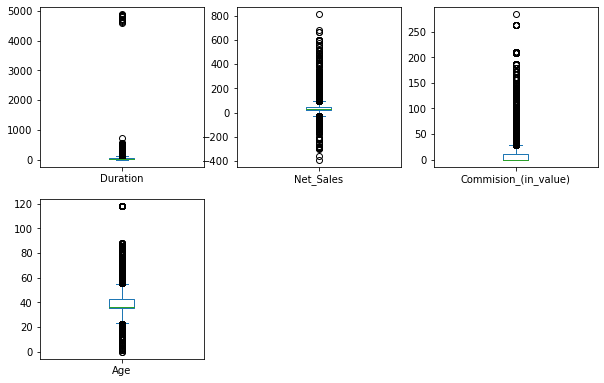

In [7]:
# 3.2 Outlier analysis 
df.plot(kind="box", subplots=True, layout=(3,3), figsize=(10,10));

#Duration: Many outliers detected that deviate far from the boxplot
#Net Sales: One outlier detected at the right whiskers
#Commision: Few outliers detected indicating abnormal high commision,possible cause of high net sales recorded
#Age: One extreme outlier indicated, possible finding at previous describe with maximum age 118

In [8]:
# Iterate over numeric columns and compute the outliers
for i in df.select_dtypes([np.int64, np.float64]).columns:
    # Interquartile range 
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1

    # Find outliers in column
    outlier = ((df[i] < (Q1 - 1.5 * IQR)) | (df[i] > (Q3 + 1.5 * IQR)))
    print(f"Variable {i}")
    print(f"Lower quartile {Q1 - 1.5 * IQR:.2f}")
    print(f"Upper quartile {Q3 + 1.5 * IQR:.2f}\n")
    df[i].describe()
    outliers=df[outlier]
    outliers.head()

Variable Duration
Lower quartile -57.00
Upper quartile 119.00

Variable Net_Sales
Lower quartile -27.00
Upper quartile 93.00

Variable Commision_(in_value)
Lower quartile -17.33
Upper quartile 28.88

Variable Age
Lower quartile 23.00
Upper quartile 55.00



In [9]:
df[df['Age']>110]

,Agency,Agency_Type,Distribution_Channel,Product_Name,Claim,Duration,Destination,Net_Sales,Commision_(in_value),Age
10,JZI,Airlines,Online,Basic Plan,No,33,"KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",-26.0,9.10,118
105,JWT,Airlines,Online,Value Plan,No,11,INDIA,50.0,20.00,118
220,JWT,Airlines,Online,Value Plan,No,4,INDIA,62.0,24.80,118
367,JWT,Airlines,Online,Value Plan,No,16,INDIA,50.0,20.00,118
402,CCR,Travel Agency,Offline,Comprehensive Plan,No,5,MALAYSIA,29.0,9.57,118
...,...,...,...,...,...,...,...,...,...,...
62920,JWT,Airlines,Online,Value Plan,No,2,INDIA,31.0,12.40,118
62953,ART,Airlines,Online,Value Plan,No,14,FRANCE,59.0,20.65,118
63096,ART,Airlines,Online,Value Plan,No,42,HONG KONG,61.0,21.35,118
63182,JWT,Airlines,Online,Value Plan,No,21,INDIA,39.0,15.60,118


In [10]:
# 3.3 Data transformation

# Define a dictionary to replace categorical values 
cleanup_nums = {
        "Distribution_Channel": {"Online": 0, "Offline": 1},
        "Claim": {"Yes": 0, "No": 1}, 
        "Gender": {"M": 0, "F": 1}, 
        "Agency_Type": {"Travel Agency": 0, "Airlines": 1}
}

# Replace categorical values with numeric 
df = df.replace(cleanup_nums)

# Obtain one hot encoding with prefix as the column name 
df_t = pd.get_dummies(df, prefix=["Agency", "Destination", "Product_Name"], columns=["Agency", "Destination", "Product_Name"])

# Replace negative duration with its mean 
df["Duration"] = df["Duration"].mask(df["Duration"] < 0, df["Duration"].mean())

# Replace extreme age with its mean 
df["Age"] = df["Age"].mask(df["Age"] > 110, df["Age"].mean())

In [11]:
# 3.5 Feature selection
# Subset columns for predictor and target variables 
X = df_t.loc[:, df_t.columns != "Claim"]
y = df_t["Claim"]

# Compute the mutual information score
mi_score = MIC(X,y, random_state=128)

# Store the mutual information score information in a dataframe 
columns = {"feature": df_t.loc[:, df_t.columns != "Claim"].columns, "mi": mi_score}
df_mi = pd.DataFrame(columns)
df_mi

,feature,mi
0,Agency_Type,0.005431
1,Distribution_Channel,0.000000
2,Duration,0.004146
3,Net_Sales,0.009523
4,Commision_(in_value),0.009991
...,...,...
192,Product_Name_Spouse or Parents Comprehensive Plan,0.000397
193,Product_Name_Ticket Protector,0.000071
194,Product_Name_Travel Cruise Protect,0.000000
195,Product_Name_Travel Cruise Protect Family,0.000000


In [12]:
# Store top 15 features into a list 
cols_to_keep = df_mi.nlargest(n=15, columns=["mi"]).feature.unique().tolist()

# # Subset the 15 features for predictor variable
X = df_t[cols_to_keep]

**4.0 Modelling and evaluation using Python**

In [13]:
# 4.1 Train test split 
# Split data into 70% train and 30% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=128)

# Oversample target variable to ensure data balance in target variable 
OS = SMOTE(random_state=128)
X_train_OS, y_train_OS = OS.fit_resample(X_train, y_train)

In [14]:
# 4.2 Model development 
# Build a random forest classifier
rf = RandomForestClassifier(random_state=128)

# Set parameters
params = {
    "n_estimators": range(25, 100, 25), 
    "max_depth": range(10, 50, 10), 
    "max_features": ["auto", "sqrt", "log2"], 
    "oob_score" : ["TRUE", "False"]
}

# 4.4 Model tuning and scoring 
full_model = GridSearchCV(
    rf, 
    param_grid=params, 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

In [ ]:
# 4.3 Model training and selection 
# Train model 
full_model.fit(X_train_OS, y_train_OS)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
# Make predictions 
predictions = full_model.predict(X_train_OS)

# 4.5 Model evaluation
# Train 
actual_train, predicted_train = y_train_OS, full_model.predict(X_train_OS)    # Compute the actual and predicted values for train dataset
accuracy_train = accuracy_score(y_train_OS, full_model.predict(X_train_OS))    # View the accuracy score for train dataset
tn_train, fp_train, fn_train, tp_train = confusion_matrix(actual_train, predicted_train).ravel()    # Construct a confusion matrix 

# Test 
actual_test, predicted_test = y_test, full_model.predict(X_test)    # Compute the actual and predicted values for test dataset
accuracy_test = accuracy_score(y_test, full_model.predict(X_test))    # View the accuracy score for test dataset
tn_test, fp_test, fn_test, tp_test = confusion_matrix(actual_test, predicted_test).ravel()

print(f"Train accuracy: {accuracy_train:.2f}\nTest accuracy: {accuracy_test:.2f}")

In [ ]:
# Plot a confusion matrix for train data 
ConfusionMatrixDisplay.from_estimator(full_model, X_train_OS, y_train_OS, display_labels=['No', 'Yes'], cmap='GnBu')

In [ ]:
# Plot a confusion matrix for test data 
ConfusionMatrixDisplay.from_estimator(full_model, X_test, y_test, display_labels=['No', 'Yes'], cmap='GnBu')

In [ ]:
# Build a XGB classifier
Ridge = RidgeClassifier(random_state=128) # Build XGB classifiers

# Set parameters
params = {
    'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]
}

# 4.4 Model tuning and scoring 
full_model2 = GridSearchCV(
    Ridge, 
    param_grid=params, 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

In [ ]:
# 4.3 Model training and selection 
# Train model 
full_model2.fit(X_train_OS, y_train_OS)

In [ ]:
# Make predictions 
predictions = full_model2.predict(X_train_OS)

# 4.5 Model evaluation
# Train 
actual_train, predicted_train = y_train_OS, full_model2.predict(X_train_OS)    # Compute the actual and predicted values for train dataset
accuracy_train = accuracy_score(y_train_OS, full_model2.predict(X_train_OS))    # View the accuracy score for train dataset
tn_train, fp_train, fn_train, tp_train = confusion_matrix(actual_train, predicted_train).ravel()

# Test 
actual_test, predicted_test = y_test, full_model2.predict(X_test)    # Compute the actual and predicted values for test dataset
accuracy_test = accuracy_score(y_test, full_model2.predict(X_test))     # View the accuracy score for test dataset
tn_test, fp_test, fn_test, tp_test = confusion_matrix(actual_test, predicted_test).ravel()

print(f"Train accuracy: {accuracy_train:.2f}\nTest accuracy: {accuracy_test:.2f}")

In [ ]:
# Plot a confusion matrix for train data 
ConfusionMatrixDisplay.from_estimator(full_model2, X_train_OS, y_train_OS, display_labels=['No', 'Yes'], cmap='GnBu')

In [ ]:
# Plot a confusion matrix for train data 
ConfusionMatrixDisplay.from_estimator(full_model2, X_test, y_test, display_labels=['No', 'Yes'], cmap='GnBu')

In [ ]:
# Random forest returns the best accuracy at 95% compared to ridge classifier at 72%
# Random forest model has the ability to distinguish those who make a travel insurance claim (the minority class) better than of ridge classifier

**References**

https://pandas.pydata.org/docs/reference/frame.html <br>
https://matplotlib.org/stable/api/matplotlib_configuration_api.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html <br> 
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html <br> 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html